# Случайный лес

Цель этого ноутбука &mdash; знакомство со случайными лесами, с их параметрами и свойствами.

In [1]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

### Основные параметры

**Реализации: `RandomForestClassifier`, `RandomForestRegressor`**

Набор гиперпараметров случайного леса очень похож на набор гиперпараметров решающего дерева. Основным отличием является наличие у случайного леса параметра `n_estimators`, задающего количество решающих деревьев, используемых для получения предсказаний. Это **основной гиперпараметр** для случайного леса.

Напомним главные гиперпараметры решающего дерева, которые также имеются у случайного леса.

* `criterion` — критерий информативности, по которому происходит разбиение вершины дерева. 

* `max_depth` — ограничение на глубину каждого дерева в лесе.

* `min_samples_split` — минимальное количество элементов обучающей выборки в вершине дерева, чтобы её можно было разбивать.

* `min_samples_leaf` — минимальное количество элементов обучающей выборке в листовой вершине.

* `splitter` — способ разбиения вершины каждого решающего дерева. Есть 2 возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.

* `max_features` — максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением дерева генерируется выборка из `min(k, max_features)` случайных признаков (`k` — количество признаков в датасете) и только эти признаки рассматриваются как разделяющие в данной вершине. <br>
Этот признак может принимать 
    * целочисленное значение — число признаков, 
    * вещественное значение — доля признаков, 
    * `None` — все признаки, 
    * `"auto"` — квадратный корень от числа всех признаков (по умолчанию), 
    * `"sqrt"` — квадратный корень от числа всех признаков, 
    * `"log2"` — двоичный логарифм от числа всех признаков.
    
* `min_impurity_decrease` — минимальное значение уменьшения взвешенного критерия неопределенности (`impurity`), чтобы можно было разбить выборку в данной вершине.

О других гиперпараметрах случайного леса можно почитать в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">документации</a>.

## Решение задачи классификации с помощью Random Forest

Возьмем классический датасет Breast Canser для определения доброкачественной или злокачественной опухоли. Его можно скачать с помощью `sklearn`, а дополнительную информацию о переменных можно почитать <a href="https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+dicancer = load_breast_cancer()
X, y = cancer.data, cancer.targetagnostic">тут</a>. 

In [2]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

### Зависимость точности классификации от значений гиперпараметров

Разобьём данные на обучающую и тестовую выборки.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Для начала попробуем оценить оптимальное количество решающих деревьев в лесе, взяв значения всех остальных параметров по умолчанию. Построим график зависимости `accuracy` от `n_estimators` на обучающей и на тестовой выборках. В большинстве случаев, значение `n_estimators` берут в диапазоне от 10 до 100. Но здесь мы рассмотрим более широкий набор значений — от 1 до 200.

In [5]:
ns = np.arange(1,201)
result_tr=[]
result_t=[]
for n in ns:
    mod = RandomForestClassifier(n_estimators=n)
    mod.fit(X_train, y_train)
    result_t.append(accuracy_score(y_test, mod.predict(X_test)))
    result_tr.append(accuracy_score(y_train, mod.predict(X_train)))

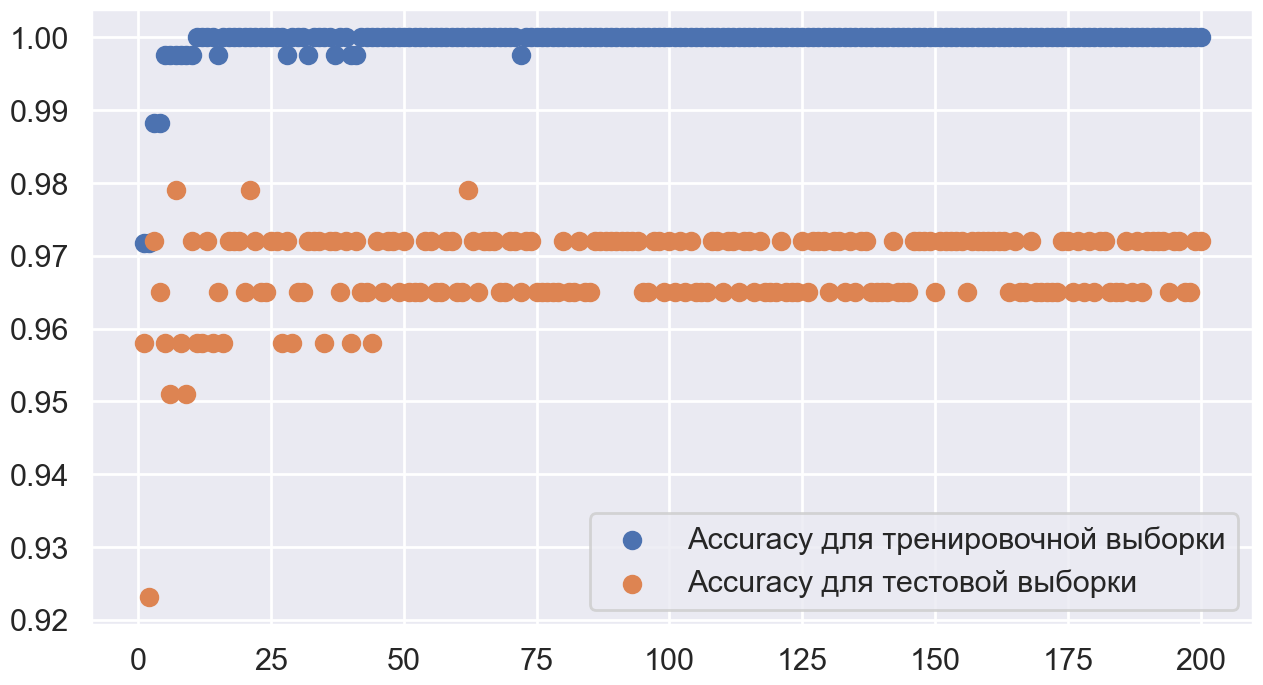

In [7]:
plt.figure(figsize=(15,8))
plt.scatter(ns, result_tr, label='Accuracy для тренировочной выборки')
plt.scatter(ns, result_t, label='Accuracy для тестовой выборки')
plt.legend()

**Выводы:** Для тренировочной выборки значение `accuracy` близко и стремится к единице, что и ожидалось, поскольку эти же данные использовались для обучения леса. Значение `Accuracy` для тренировочной выборки перестаёт расти примерно при N>40 и имеет высокое значение $\approx 0.97$, вокруг котрого оно флуктуирует

В теории, при предположении, что все решающие деревья в лесе независимы между собой, должно получаться, что при увеличении числа случайных решающих деревьев в лесе дисперсия предсказания монотонно снижается, а точность монотонно повышается. Однако из-за того, что на практике решающие деревья попарно скоррелированны, такой эффект наблюдается лишь до некоторого значения `n_estimators`, а затем значительных изменений не происходит.

Определите из графика оптимальное значение `n_estimators` и используйте это значение во всех последующих экспериментах с данным датасетом. Построим график зависимости `accuracy` от `min_samples_leaf` на обучающей и на тестовой выборках.

In [10]:
N_opt=50


In [11]:
msl = np.arange(1,450)
result_tr=[]
result_t=[]
for ms in msl:
    mod = RandomForestClassifier(min_samples_leaf=ms)
    mod.fit(X_train, y_train)
    result_t.append(accuracy_score(y_test, mod.predict(X_test)))
    result_tr.append(accuracy_score(y_train, mod.predict(X_train)))

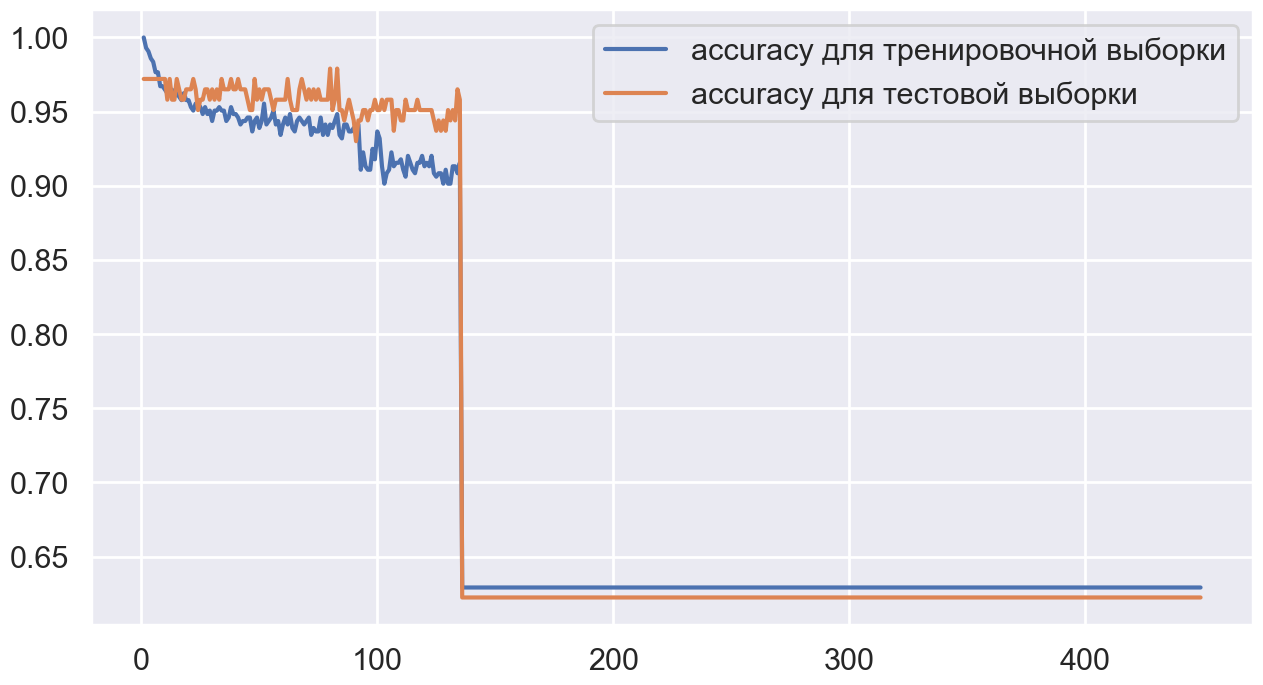

In [16]:
plt.figure(figsize=(15,8))
plt.plot(msl, result_tr, label='accuracy для тренировочной выборки')
plt.plot(msl, result_t, label='accuracy для тестовой выборки')
plt.legend()

Обрежем график по оси X

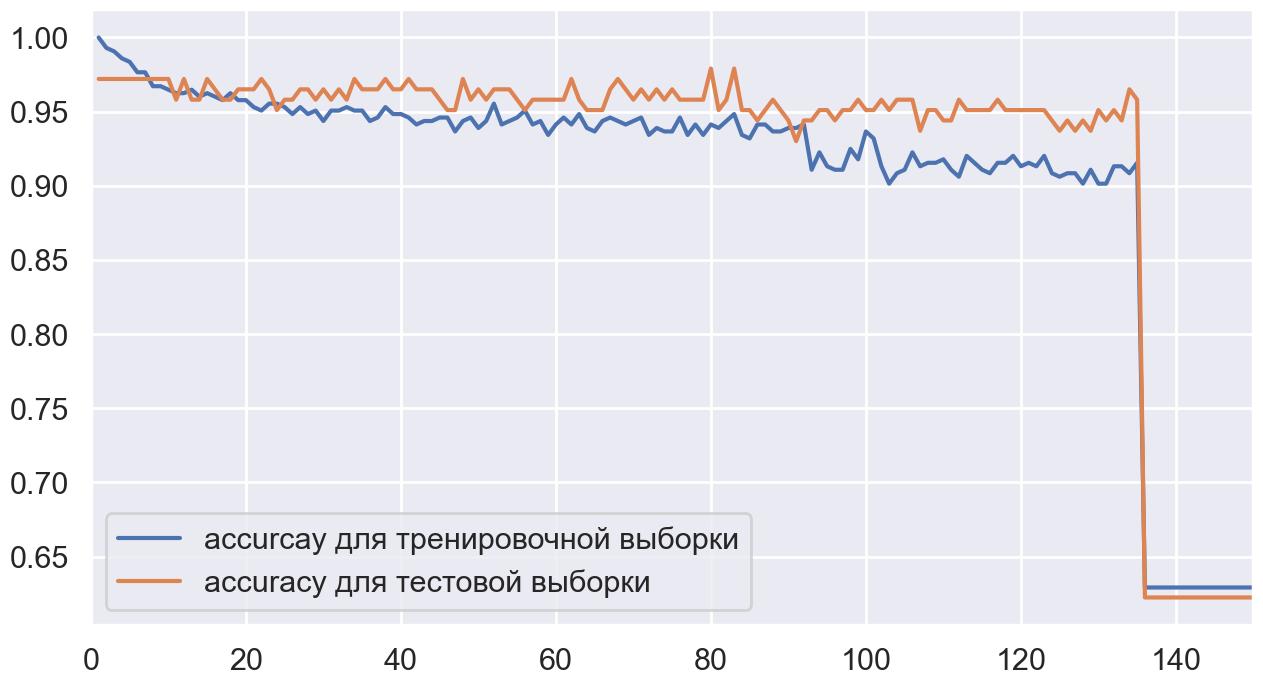

In [17]:
plt.figure(figsize=(15,8))
plt.plot(msl, result_tr, label='accurcay для тренировочной выборки')
plt.plot(msl, result_t, label='accuracy для тестовой выборки')
plt.xlim(0,150)
plt.legend()

**Выводы:** Значение для тестовой выборки оказывается в среднем выше. В районе оптимального N=50 значение примерно 0.97.

Теперь повторим повторим эксперимент для параметра `min_samples_split`.

In [18]:
mss = np.arange(2,300)
result_tr=[]
result_t=[]
for ms in mss:
    mod = RandomForestClassifier(min_samples_split=ms)
    mod.fit(X_train, y_train)
    result_t.append(accuracy_score(y_test, mod.predict(X_test)))
    result_tr.append(accuracy_score(y_train, mod.predict(X_train)))

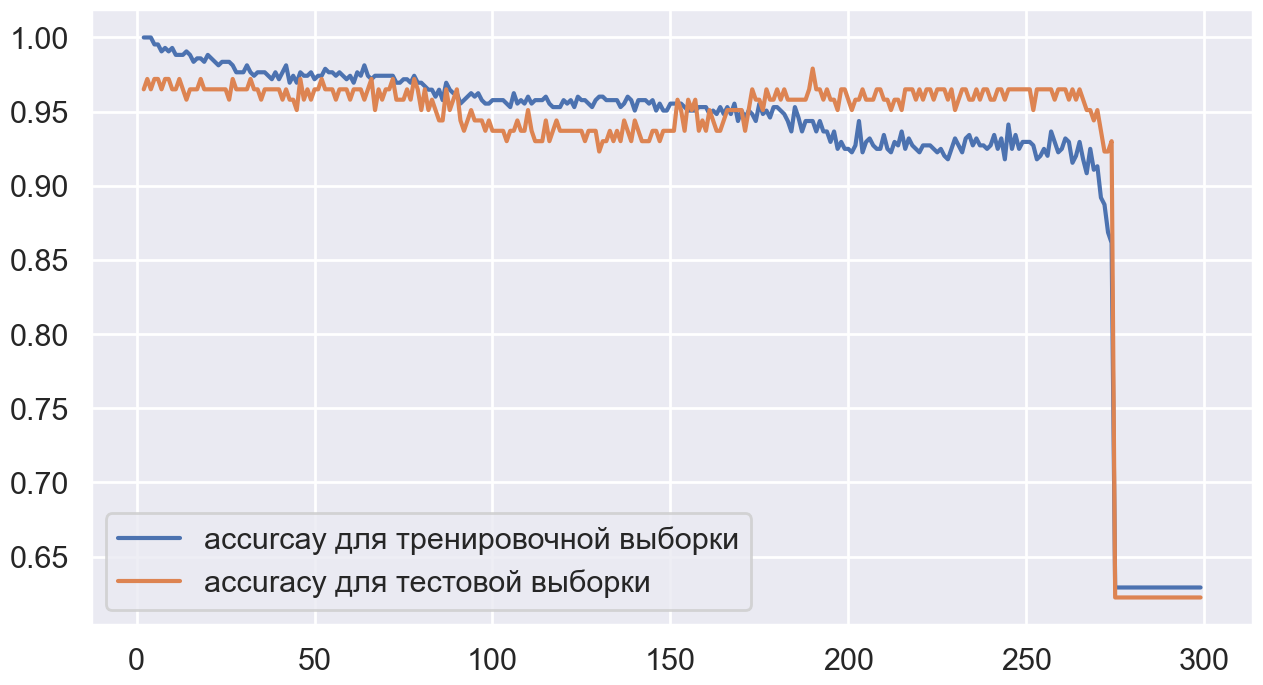

In [20]:
plt.figure(figsize=(15,8))
plt.plot(mss, result_tr, label='accurcay для тренировочной выборки')
plt.plot(mss, result_t, label='accuracy для тестовой выборки')
#plt.xlim(0,150)
plt.legend()

In [22]:
result_t[N_opt]

0.972027972027972

**Выводы:**

Значение `accuracy` для тренировочной выборки в среднем падает. Для тестовой выборки значение `accuracy` меняется немонотонно и незначительно. При оптимальном N=50 значение получилось 0.972

**Общие выводы по всей задаче:**

Изменяя параметры `n_estimators`, `min_samples_leaf`, `min_samples_split` мы можем добиться лучших значений метрик качства для конкретной задачи.

Значение `n_estimators` стоит брать как можно больше, так как значение accuracy монотонно растёт с ним. 

`min_samples_leaf`, `min_samples_split` Чтобы исключить влияние выбросов на результат